# Health Insurance fraud detection using Medicare Providers dataset

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib
import os
%matplotlib inline
from IPython.display import display, HTML
from pathlib import Path

In [2]:
#Change directory to root
path = Path(os.getcwd())
root_dir = path.parent.absolute()
os.chdir(str(root_dir))

## 3. Exploratory data analysis (EDA)

In [3]:
df_cms = pd.read_csv('data\processed\Clean_CMS_Provider(2016_2019).csv')

In [4]:
df_cms.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
0,1003000126,Internal Medicine,MD,M,23,232.000,75,1477.000,518,2.024,746533.000,124795.990,2016,0
1,1003000126,Internal Medicine,MD,M,19,182.000,76,1218.000,445,2.295,692640.000,102505.730,2018,0
2,1003000126,Internal Medicine,MD,M,18,265.000,75,1392.000,610,2.592,519136.000,124877.670,2019,0
3,1003000126,Internal Medicine,MD,M,23,240.000,75,1670.000,578,2.118,800850.000,137084.550,2017,0
4,1003000134,Pathology,IL,M,21,1703.000,76,7329.000,3322,1.090,1143597.000,214070.990,2018,0


In [5]:
df_cms.shape

(4174813, 14)

In [6]:
df_cms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174813 entries, 0 to 4174812
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Rndrng_NPI                 int64  
 1   Rndrng_Prvdr_Type          object 
 2   Rndrng_Prvdr_State_Abrvtn  object 
 3   Rndrng_Prvdr_Gndr          object 
 4   Tot_HCPCS_Cds              int64  
 5   Bene_Male_Cnt              float64
 6   Bene_Avg_Age               int64  
 7   Tot_Srvcs                  float64
 8   Tot_Benes                  int64  
 9   Bene_Avg_Risk_Scre         float64
 10  Tot_Sbmtd_Chrg             float64
 11  Tot_Mdcr_Pymt_Amt          float64
 12  year                       int64  
 13  Fraud                      int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 445.9+ MB


### Fraud rate

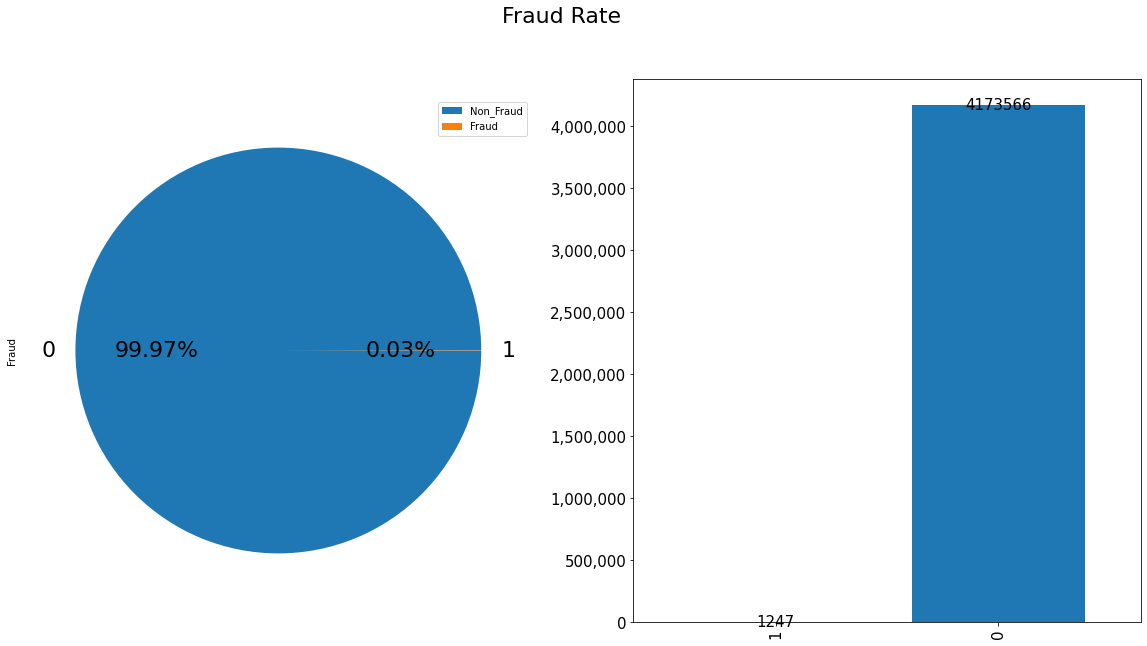

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax7 = df_cms['Fraud'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',
rot = 0 ,fontsize = "22" ,ax=axes[0])
ax7.legend( labels=['Non_Fraud','Fraud'], loc='best')

plt.suptitle('Fraud Rate \n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")

ax77=df_cms['Fraud'].value_counts(ascending=True).plot(kind='bar',ax=axes[1],fontsize=15,width=0.78)
# ax9.set_title(label='Fraud By Gender',fontsize=15)
for p in ax77.patches:                 
    ax77.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=15)
ax77.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

__The fraud rate (0.03%) does not reflect reality (10% worldwide), therefore it is necessary to select a sample of the negative class (population) to increase the fraud rate up to 10%.__

### Negative class sampling :

In [8]:
#Split fraudulent and non-fraudulent providers :
df_neg=df_cms[df_cms['Fraud']==0]
df_pos=df_cms[df_cms['Fraud']==1]

In [9]:
#Sample:
sp=df_neg.sample(n=df_pos.shape[0]*9, random_state=1)

__Statistical tests to check if sample is biased :__

___H0 : The population and the sample have the same distribution.___

__if pvalue(feature)> 0.05; H0 is retained and the sample is unbiased.__

In [10]:
from scipy.stats import kstest
from scipy.stats import chisquare

__Numeric features :__

In [11]:
print('Kolmogorov-Smirnov test for numerical features :\n')
num_feat=['Tot_Benes',"Tot_Srvcs",'Tot_Sbmtd_Chrg','Tot_Mdcr_Pymt_Amt','Tot_HCPCS_Cds','Bene_Male_Cnt','Bene_Avg_Age'
         ,'Bene_Avg_Risk_Scre']
for f in num_feat :
    print('pvalue('+f+')',kstest(df_neg[f], sp[f]).pvalue)

Kolmogorov-Smirnov test for numerical features :

pvalue(Tot_Benes) 0.8969096079768729
pvalue(Tot_Srvcs) 0.9994320173000142
pvalue(Tot_Sbmtd_Chrg) 0.5455136135071752
pvalue(Tot_Mdcr_Pymt_Amt) 0.8863955786787648
pvalue(Tot_HCPCS_Cds) 0.49345248556523635
pvalue(Bene_Male_Cnt) 0.39165482073604296
pvalue(Bene_Avg_Age) 0.991574514429479
pvalue(Bene_Avg_Risk_Scre) 0.46466381128823364


In [12]:
print('Population : ')
display(df_neg[num_feat].describe())
print('Sample :')
display(sp[num_feat].describe())
#First table : population
#Second table : sample

Population : 


,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Bene_Avg_Risk_Scre
count,4173566.000,4173566.000,4173566.000,4173566.000,4173566.000,4173566.000,4173566.000,4173566.000
mean,325.437,2328.223,309185.221,80763.113,31.271,146.873,70.728,1.654
std,574.380,14472.584,762248.494,217910.724,32.807,245.938,5.986,0.809
min,11.000,11.000,0.400,0.000,1.000,0.000,6.000,0.328
25%,64.000,186.000,36360.000,10827.312,10.000,41.000,69.000,1.097
50%,168.000,535.000,120477.745,31513.765,20.000,82.000,72.000,1.433
75%,370.000,1548.000,323879.883,81599.477,42.000,158.000,74.000,2.009
max,153032.000,4653415.000,57638473.840,19769878.960,664.000,67657.000,95.000,14.464


Sample :


,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Bene_Avg_Risk_Scre
count,11223.000,11223.000,11223.000,11223.000,11223.000,11223.000,11223.000,11223.000
mean,330.700,2634.909,317618.740,82733.843,31.142,148.159,70.722,1.661
std,589.623,17205.678,903512.493,240539.585,33.090,259.121,6.054,0.819
min,11.000,11.000,195.420,34.190,1.000,0.000,13.000,0.391
25%,64.000,185.000,36491.500,10772.950,10.000,39.000,69.000,1.096
50%,169.000,531.000,122571.000,31748.760,20.000,82.000,72.000,1.441
75%,366.000,1555.500,319195.935,81273.395,41.000,154.000,74.000,2.028
max,20616.000,750525.000,43568221.540,8556096.630,290.000,11497.000,89.000,11.138


__Variables catégorielles :__

In [13]:
#speciality
type_dict_sp=sp['Rndrng_Prvdr_Type'].value_counts().to_dict() #speciality from sample
type_dict_pp=df_neg['Rndrng_Prvdr_Type'].value_counts().to_dict() #speciality from population
type_pp=[] #frequency vector
type_sp=[] #frequency vector

#some "specialities are not selected during sampling, their frequency is replaced by 0"
for key in type_dict_pp:
    type_pp.append(type_dict_pp[key])
    if(key in type_dict_sp):
        type_sp.append(type_dict_sp[key])
    else:
        type_sp.append(0)

In [14]:
#state
state_dict_sp=sp['Rndrng_Prvdr_State_Abrvtn'].value_counts().to_dict()
state_dict_pp=df_neg['Rndrng_Prvdr_State_Abrvtn'].value_counts().to_dict()
state_pp=[]
state_sp=[]
for key in state_dict_pp:
    state_pp.append(state_dict_pp[key])
    if(key in state_dict_sp):
        state_sp.append(state_dict_sp[key])
    else:
        state_sp.append(0)

In [15]:
print('Chi-square test for categorical features :\n')
cat_feat=['year',"Rndrng_Prvdr_Gndr"]
for f in cat_feat :
    sp_cat=list(sp[f].value_counts())/np.sum(list(sp[f].value_counts()))
    pop_cat=list(df_neg[f].value_counts()/np.sum(list(df_neg[f].value_counts())))
    print('pvalue('+f+')',chisquare(sp_cat, pop_cat).pvalue)
print('pvalue(Rndrng_Prvdr_Type)',chisquare(type_sp/np.sum(type_sp), type_pp/np.sum(type_pp)).pvalue)
print('pvalue(Rndrng_Prvdr_State_Abrvtn)',chisquare(state_sp/np.sum(state_sp), state_pp/np.sum(state_pp)).pvalue)

Chi-square test for categorical features :

pvalue(year) 0.9999991515918233
pvalue(Rndrng_Prvdr_Gndr) 0.9937300957534914
pvalue(Rndrng_Prvdr_Type) 1.0
pvalue(Rndrng_Prvdr_State_Abrvtn) 1.0


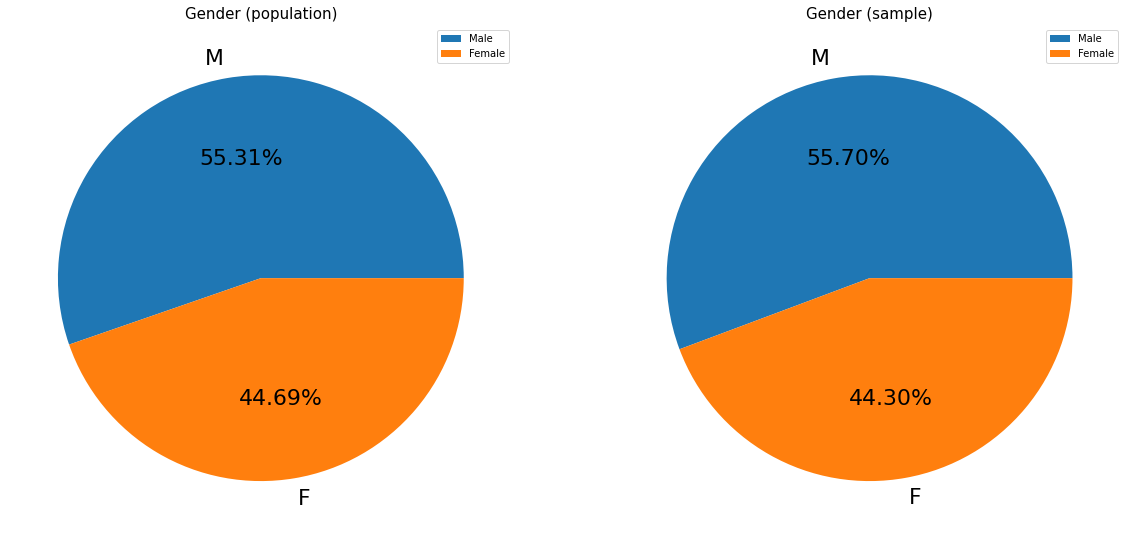

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax5 = df_neg['Rndrng_Prvdr_Gndr'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "22" ,ax=axes[0],label='')
ax5.legend( labels=['Male','Female'], loc='best')
ax5.set_title(label='Gender (population)',fontsize=15)

ax6 = sp['Rndrng_Prvdr_Gndr'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "22" ,ax=axes[1],label='')
ax6.legend( labels=['Male','Female'], loc='best')
ax6.set_title(label='Gender (sample)',fontsize=15)

plt.show()

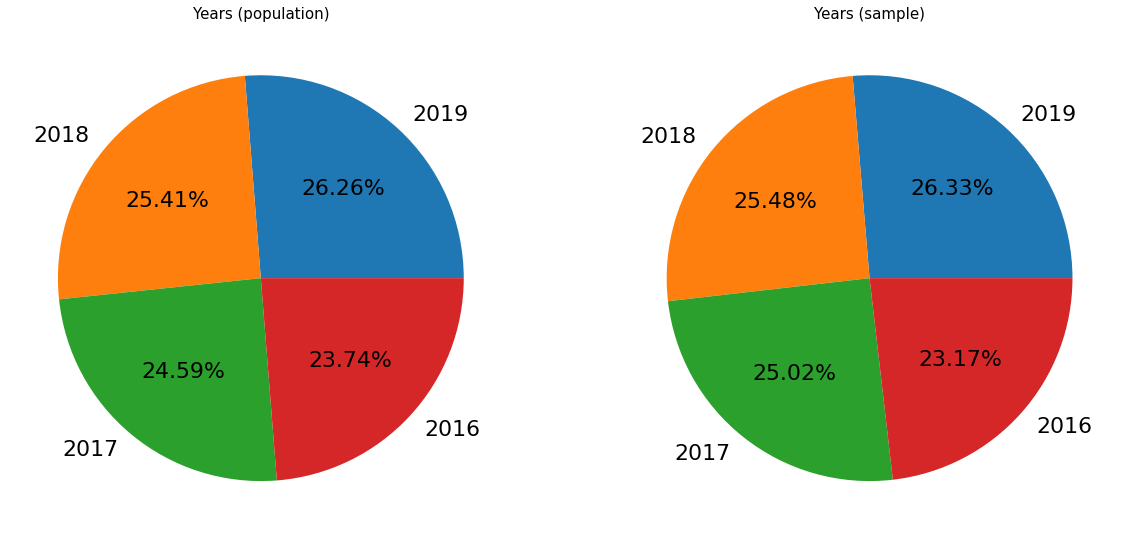

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax5 = df_neg['year'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "22" ,ax=axes[0],label='')
# ax5.legend( labels=['Male','Female'], loc='best')
ax5.set_title(label='Years (population)',fontsize=15)

ax6 = sp['year'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "22" ,ax=axes[1],label='')
# ax6.legend( labels=['Male','Female'], loc='best')
ax6.set_title(label='Years (sample)',fontsize=15)

plt.show()

In [18]:
print('Top 10 most common providers type (population):')
display((df_neg['Rndrng_Prvdr_Type'].value_counts()*100/df_neg.shape[0]).to_frame().head(10))
print('Top 10 most common providers type (sample):')
display((sp['Rndrng_Prvdr_Type'].value_counts().to_frame()*100/sp.shape[0]).head(10))

Top 10 most common providers type (population):


,Rndrng_Prvdr_Type
Nurse Practitioner,11.399
Internal Medicine,9.214
Family Practice,8.082
Physician Assistant,7.147
Physical Therapist in Private Practice,5.063
Certified Registered Nurse Anesthetist (CRNA),4.235
Emergency Medicine,4.228
Anesthesiology,3.696
Chiropractic,3.396
Diagnostic Radiology,2.911


Top 10 most common providers type (sample):


,Rndrng_Prvdr_Type
Nurse Practitioner,11.138
Internal Medicine,9.391
Family Practice,7.511
Physician Assistant,7.342
Physical Therapist in Private Practice,5.025
Emergency Medicine,4.348
Certified Registered Nurse Anesthetist (CRNA),4.170
Anesthesiology,3.787
Chiropractic,3.591
Diagnostic Radiology,3.021


In [19]:
#Final Dataset ==> Concatenating sample with fraudulent providers
df_final=pd.concat([sp,df_pos])

In [20]:
print('the final dataset contains '+str(df_final.shape[0])+' rows')

the final dataset contains 12470 rows


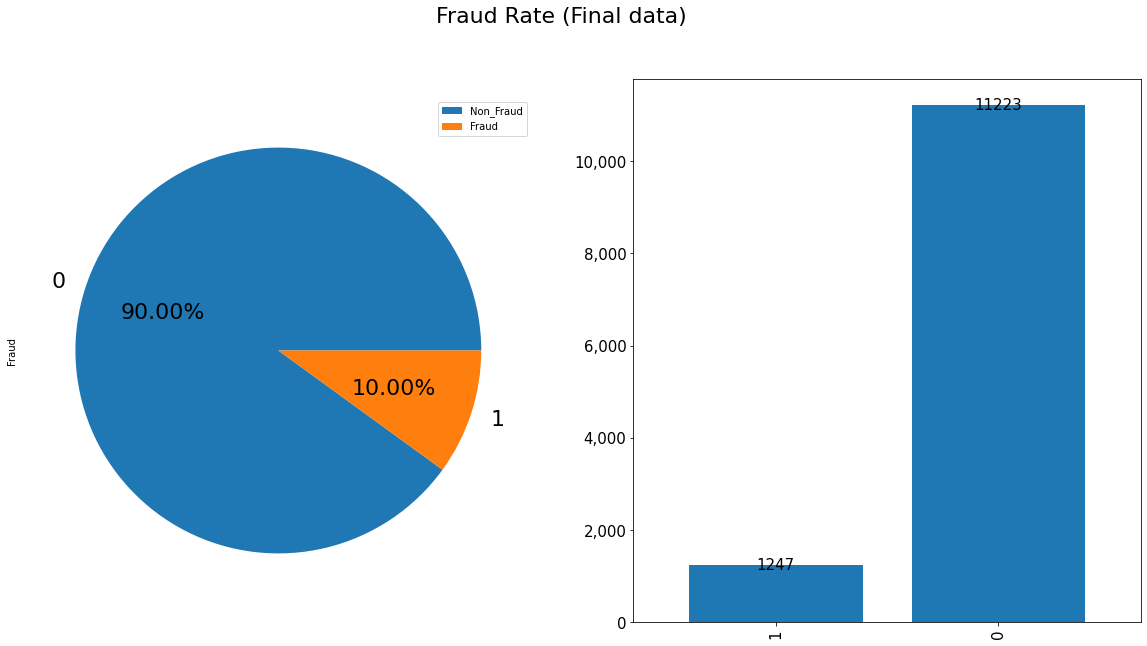

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax7 = df_final['Fraud'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',
rot = 0 ,fontsize = "22" ,ax=axes[0])
ax7.legend( labels=['Non_Fraud','Fraud'], loc='best')

plt.suptitle('Fraud Rate (Final data) \n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")

ax77=df_final['Fraud'].value_counts(ascending=True).plot(kind='bar',ax=axes[1],fontsize=15,width=0.78)
# ax9.set_title(label='Fraud By Gender',fontsize=15)
for p in ax77.patches:                 
    ax77.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=15)
ax77.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [22]:
#saving final dataframe as CSV
df_final.to_csv("data\processed\Sampled_Medicare_Data.csv",index=False) 

### 3.1. Univariate analysis

#### 3.1.1 Numerical features

In [23]:
num_feat

['Tot_Benes',
 'Tot_Srvcs',
 'Tot_Sbmtd_Chrg',
 'Tot_Mdcr_Pymt_Amt',
 'Tot_HCPCS_Cds',
 'Bene_Male_Cnt',
 'Bene_Avg_Age',
 'Bene_Avg_Risk_Scre']

In [24]:
df_final[num_feat].describe()

,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Bene_Avg_Risk_Scre
count,12470.000,12470.000,12470.000,12470.000,12470.000,12470.000,12470.000,12470.000
mean,324.570,2686.296,325777.965,87036.529,30.872,146.067,70.486,1.658
std,570.652,16681.180,916770.661,244864.665,32.442,251.762,6.195,0.820
min,11.000,11.000,131.800,0.000,1.000,0.000,13.000,0.391
25%,64.000,191.000,36631.885,10995.017,10.000,39.000,69.000,1.100
50%,168.000,559.000,123006.000,32796.065,20.000,82.000,72.000,1.441
75%,362.750,1645.000,325702.125,85417.542,41.000,154.000,74.000,2.014
max,20616.000,750525.000,43568221.540,8556096.630,290.000,11497.000,89.000,11.138


In [25]:
df_final[num_feat].quantile([0.05, 0.25, 0.5, 0.75, 0.95,0.99,1])

,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Bene_Avg_Risk_Scre
0.050,18.000,41.000,6486.566,2078.668,2.000,13.000,58.000,0.829
0.250,64.000,191.000,36631.885,10995.017,10.000,39.000,69.000,1.100
0.500,168.000,559.000,123006.000,32796.065,20.000,82.000,72.000,1.441
0.750,362.750,1645.000,325702.125,85417.542,41.000,154.000,74.000,2.014
0.950,1103.550,7051.000,1121563.087,285603.178,92.000,490.000,78.000,3.086
0.990,2837.620,30561.910,2929443.210,879170.770,164.000,1201.000,82.000,4.425
1.000,20616.000,750525.000,43568221.540,8556096.630,290.000,11497.000,89.000,11.138


__OUTLIERS PRESENCE !!!!!__

In [26]:
# calculate Q1 and Q3
df_out=df_final[[f for f in df_cms.columns if f!='Rndrng_NPI' and f!='Fraud' and f!='year']]

Q1 = df_out.quantile(0.25)
Q3 = df_out.quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# filter the dataset with the IQR
IQR_outliers = df_final[((df_final < (Q1 - 1.5 * IQR)) |(df_final > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_7028\3383125702.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  IQR_outliers = df_final[((df_final < (Q1 - 1.5 * IQR)) |(df_final > (Q3 + 1.5 * IQR))).any(axis=1)]


In [27]:
#Remove all outliers
df_cms_clean=df_final[~(df_final > (Q3 + 1.5 * IQR)).any(axis=1)] 

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_7028\3926277016.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_cms_clean=df_final[~(df_final > (Q3 + 1.5 * IQR)).any(axis=1)]


In [28]:
print('There are '+str(IQR_outliers.shape[0])+' outliers prensents in the dataset')
print('Outliers percentage :'+str( IQR_outliers.shape[0]*100/df_final.shape[0]) +'%')

There are 3824 outliers prensents in the dataset
Outliers percentage :30.665597433841217%


In [29]:
outliers=dict()
for f in num_feat:
    df_out=df_cms[f]
    q1 = df_out.quantile(0.25)
    q3 = df_out.quantile(0.75)

    # calculate the IQR
    iqr = q3 - q1

    # filter the dataset with the IQR
    IQR_outliers = df_final[((df_final[f] < (q1 - 1.5 * iqr)) |(df_cms[f] > (q3 + 1.5 * iqr)))]
    outliers[f]=IQR_outliers.shape[0]

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_7028\2620083206.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  IQR_outliers = df_final[((df_final[f] < (q1 - 1.5 * iqr)) |(df_cms[f] > (q3 + 1.5 * iqr)))]


In [30]:
df_outl=pd.DataFrame.from_dict(outliers,orient='index',columns=['Outliers'])
df_outl['Percentage']=df_outl['Outliers']/df_final.shape[0]*100
df_outl.sort_values(by=['Percentage'],ascending=False)

,Outliers,Percentage
Tot_Srvcs,1474,11.820
Tot_Sbmtd_Chrg,1207,9.679
Tot_Mdcr_Pymt_Amt,1201,9.631
Bene_Avg_Age,1131,9.070
Bene_Male_Cnt,1083,8.685
Tot_Benes,953,7.642
Tot_HCPCS_Cds,655,5.253
Bene_Avg_Risk_Scre,393,3.152


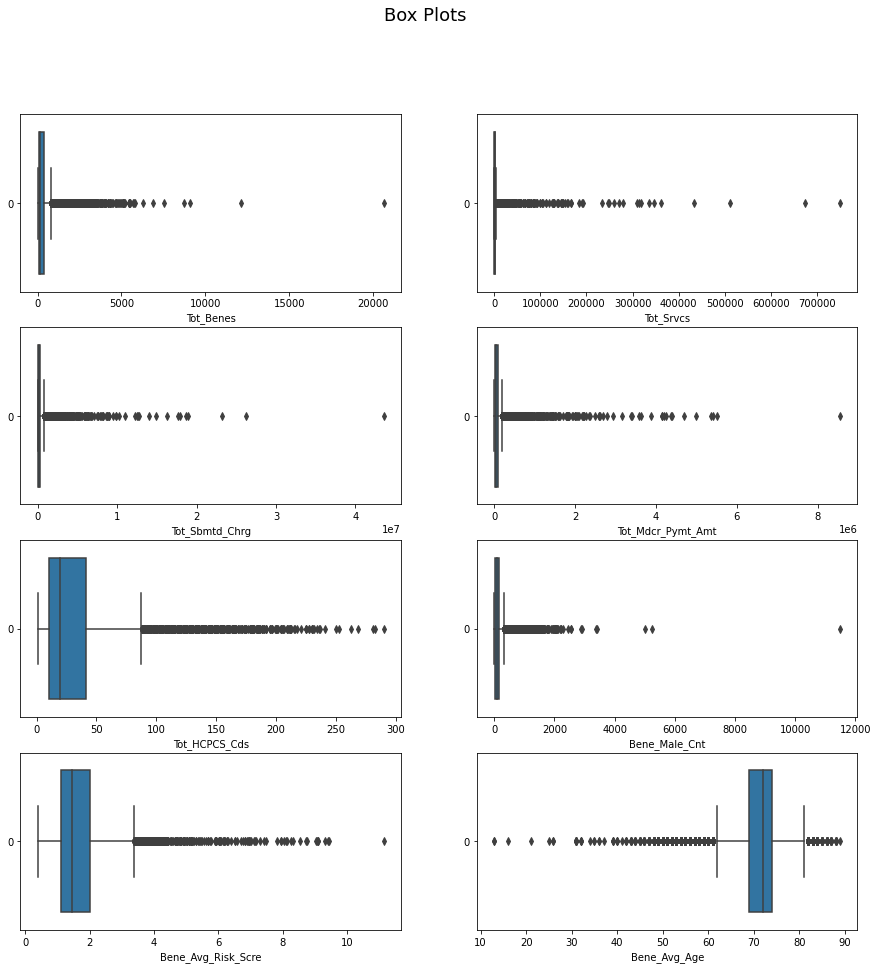

In [31]:
#BOX PLOTS

plt.rcParams["figure.figsize"] = (15,15)
fig, axes = plt.subplots(nrows=4, ncols=2)
plt.suptitle('Box Plots',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "18", fontfamily = "sans-serif")

ax= sns.boxplot(x=df_final["Tot_Benes"],ax=axes[0,0])
ax2=sns.boxplot(x=df_final["Tot_Srvcs"],ax=axes[0,1])

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax33= sns.boxplot(x=df_final["Tot_Sbmtd_Chrg"],ax=axes[1,0])
ax32=sns.boxplot(x=df_final["Tot_Mdcr_Pymt_Amt"],ax=axes[1,1])

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax33= sns.boxplot(x=df_final["Tot_HCPCS_Cds"],ax=axes[2,0])
ax32=sns.boxplot(x=df_final["Bene_Male_Cnt"],ax=axes[2,1])

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax33= sns.boxplot(x=df_final["Bene_Avg_Risk_Scre"],ax=axes[3,0])
ax32=sns.boxplot(x=df_final["Bene_Avg_Age"],ax=axes[3,1])

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [32]:
nb_bins = 1+np.ceil(np.log2(df_final.shape[0]))
print("Number of bins using sturge's rule :",nb_bins) 
nb_bins=int(nb_bins)

Number of bins using sturge's rule : 15.0


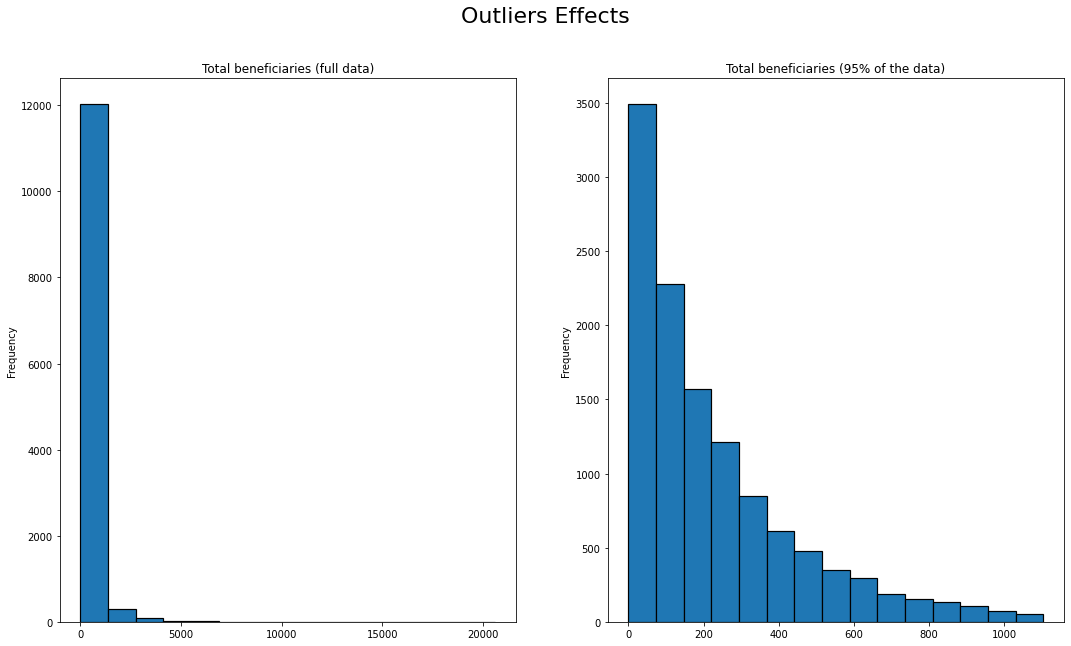

In [33]:
#outliers effect
plt.rcParams["figure.figsize"] = (18,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.suptitle('Outliers Effects\n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")

ax=df_final['Tot_Benes'].plot(kind='hist', title='Total beneficiaries (full data)',bins=nb_bins, ax=axes[0],
                              edgecolor='black',linewidth=1.2)

ax2=df_final['Tot_Benes'].plot(kind='hist', title='Total beneficiaries (95% of the data)',bins=nb_bins,range=[0,1103.55] ,
                               ax=axes[1],edgecolor='black' ,linewidth=1.2)



plt.show()

In [34]:
df_final[num_feat].quantile([0.05, 0.25, 0.5, 0.75, 0.95,0.99,1])

,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Bene_Avg_Risk_Scre
0.050,18.000,41.000,6486.566,2078.668,2.000,13.000,58.000,0.829
0.250,64.000,191.000,36631.885,10995.017,10.000,39.000,69.000,1.100
0.500,168.000,559.000,123006.000,32796.065,20.000,82.000,72.000,1.441
0.750,362.750,1645.000,325702.125,85417.542,41.000,154.000,74.000,2.014
0.950,1103.550,7051.000,1121563.087,285603.178,92.000,490.000,78.000,3.086
0.990,2837.620,30561.910,2929443.210,879170.770,164.000,1201.000,82.000,4.425
1.000,20616.000,750525.000,43568221.540,8556096.630,290.000,11497.000,89.000,11.138


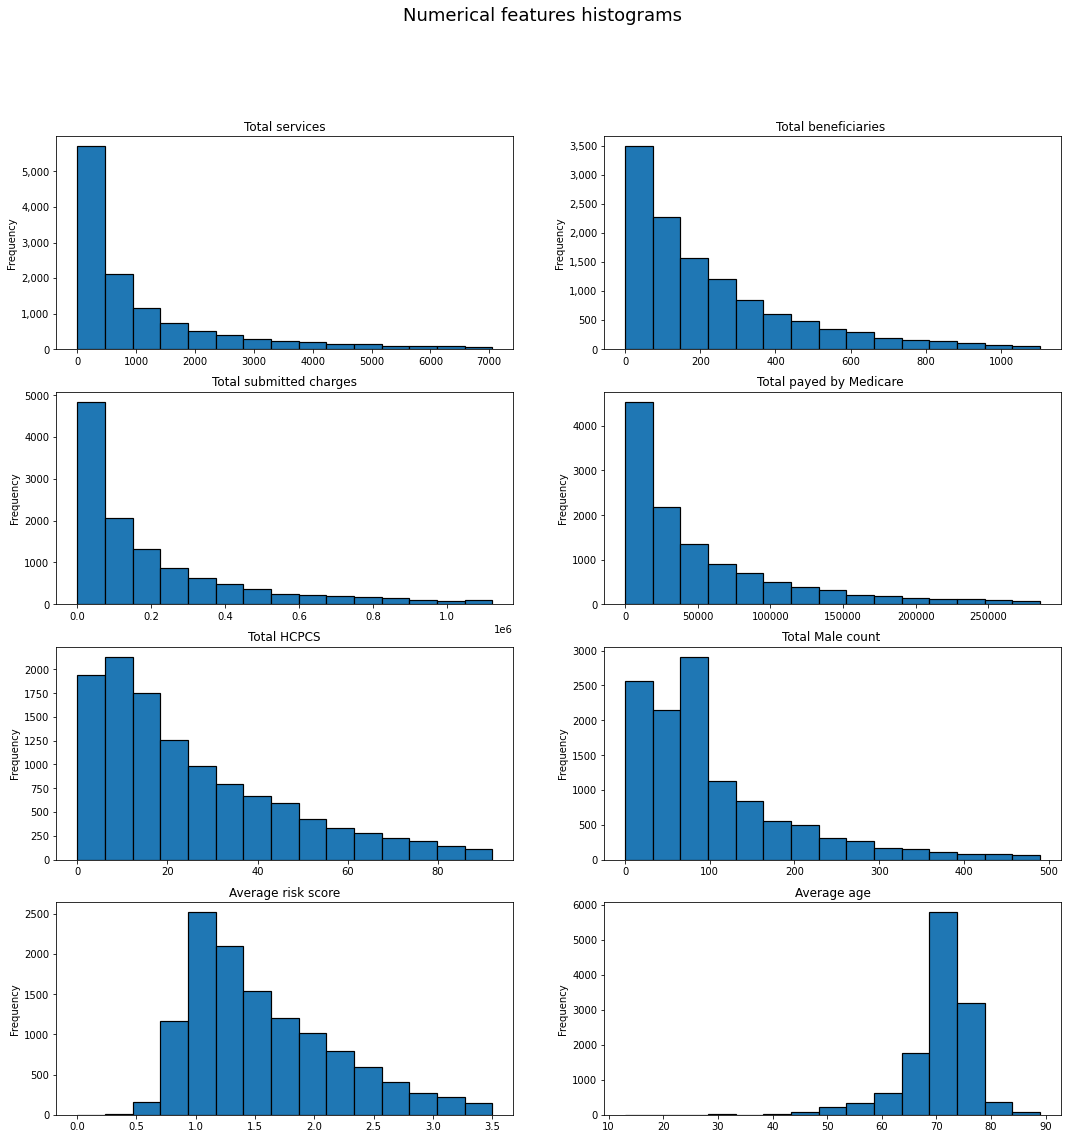

In [35]:
#histograms using 95% of the data

plt.rcParams["figure.figsize"] = (18,18)
fig, axes = plt.subplots(nrows=4, ncols=2)
plt.suptitle('Numerical features histograms',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "18", fontfamily = "sans-serif")

ax=df_final['Tot_Srvcs'].plot(kind='hist', title='Total services',bins=nb_bins, ax=axes[0,0],edgecolor='black',
                            range=[0,7051],linewidth=1.2)

ax2=df_final['Tot_Benes'].plot(kind='hist', title='Total beneficiaries ',bins=nb_bins,range=[0,1103.55] ,
                               ax=axes[0,1],edgecolor='black' ,linewidth=1.2)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax=df_final['Tot_Sbmtd_Chrg'].plot(kind='hist', title='Total submitted charges',bins=nb_bins, ax=axes[1,0],edgecolor='black',
                            range=[0,1121563.087],linewidth=1.2)

ax2=df_final['Tot_Mdcr_Pymt_Amt'].plot(kind='hist', title='Total payed by Medicare ',bins=nb_bins,range=[0,285603.178] ,
                               ax=axes[1,1],edgecolor='black' ,linewidth=1.2)

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax=df_final['Tot_HCPCS_Cds'].plot(kind='hist', title='Total HCPCS',bins=nb_bins, ax=axes[2,0],edgecolor='black',
                            range=[0,92],linewidth=1.2)

ax2=df_final['Bene_Male_Cnt'].plot(kind='hist', title='Total Male count ',bins=nb_bins,range=[0,490.000] ,
                               ax=axes[2,1],edgecolor='black' ,linewidth=1.2)

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax=df_final['Bene_Avg_Age'].plot(kind='hist', title='Average age',bins=nb_bins, ax=axes[3,1],edgecolor='black',
                            linewidth=1.2)

ax2=df_final['Bene_Avg_Risk_Scre'].plot(kind='hist', title='Average risk score',bins=nb_bins ,
                               ax=axes[3,0],edgecolor='black' ,range=[0,3.5],linewidth=1.2)

ax33.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#### 3.1.2 Categorical feautres

In [36]:
cat_feat=[f for f in df_final.columns if f not in num_feat and f != 'Rndrng_NPI' ]
cat_feat

['Rndrng_Prvdr_Type',
 'Rndrng_Prvdr_State_Abrvtn',
 'Rndrng_Prvdr_Gndr',
 'year',
 'Fraud']

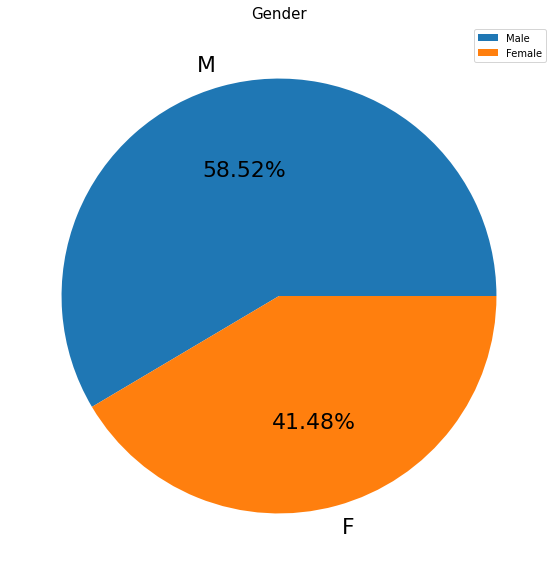

In [37]:
#Gender distribution
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=1)

ax5 = df_final['Rndrng_Prvdr_Gndr'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',fontsize = "22" ,ax=axes,label='')
ax5.legend( labels=['Male','Female'], loc='best')
ax5.set_title(label='Gender',fontsize=15)


plt.show()

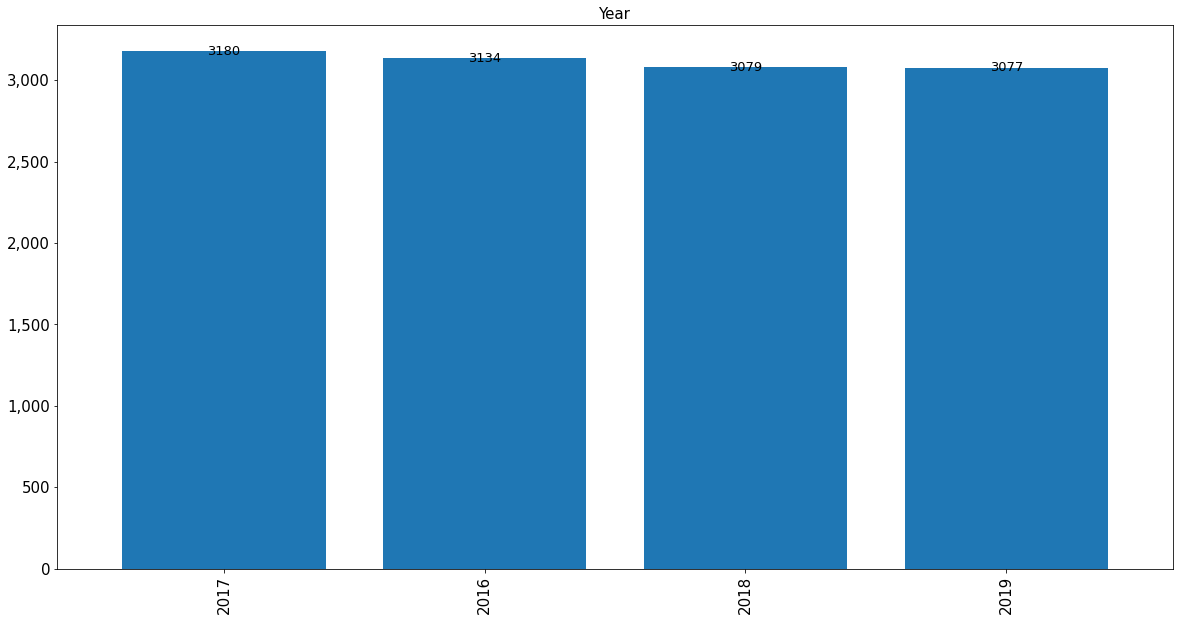

In [38]:
#years distribution

plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=1)

ax6=df_final['year'].value_counts().plot(kind='bar',ax=axes,fontsize=15,width=0.78)
ax6.set_title(label='Year',fontsize=15)
for p in ax6.patches:                 
    ax6.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=13)
    
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

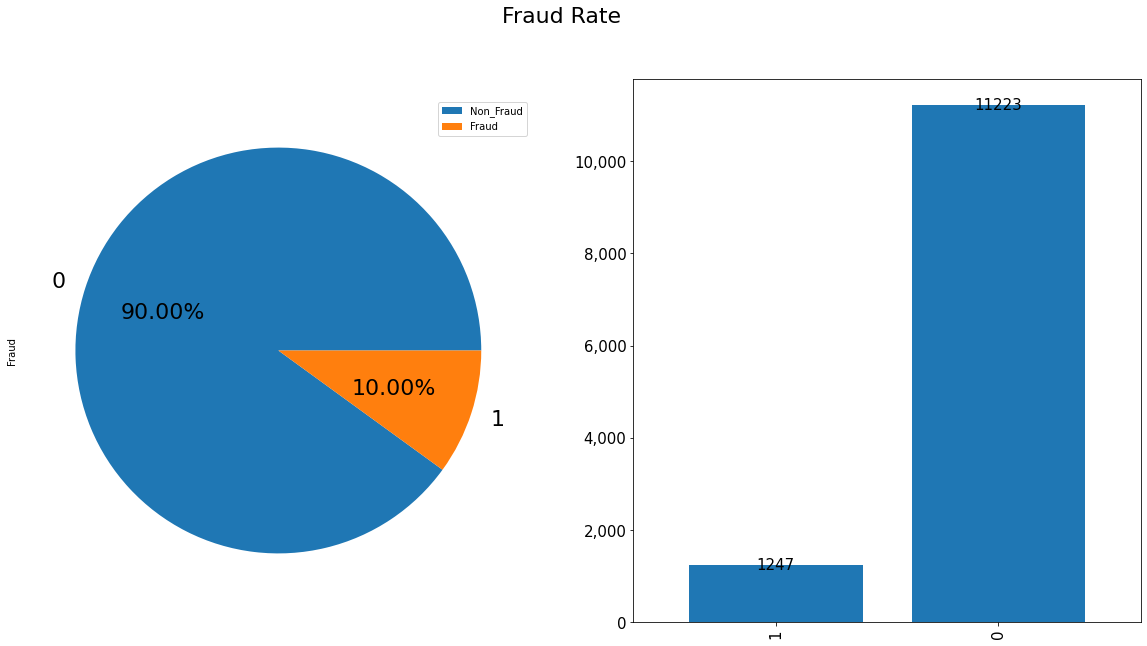

In [39]:
#Fraud rate

plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

ax7 = df_final['Fraud'].value_counts().plot(
kind = 'pie',autopct='%.2f%%',
rot = 0 ,fontsize = "22" ,ax=axes[0])
ax7.legend( labels=['Non_Fraud','Fraud'], loc='best')
# plt.title('Fraud Rate  \n',
# horizontalalignment="center", fontstyle = "normal", 
# fontsize = "22", fontfamily = "sans-serif")


plt.suptitle('Fraud Rate \n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")

ax77=df_final['Fraud'].value_counts(ascending=True).plot(kind='bar',ax=axes[1],fontsize=15,width=0.78)
# ax9.set_title(label='Fraud By Gender',fontsize=15)
for p in ax77.patches:                 
    ax77.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=15)
ax77.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [40]:
print(df_final['Rndrng_Prvdr_Type'].nunique() ,'unique type values')#can't visualize this feature becaue 95 is too high
print(df_final['Rndrng_Prvdr_State_Abrvtn'].nunique() ,'unique type values')#can't visualize this feature becaue 57 is too high

80 unique type values
57 unique type values


In [41]:
print('Top 10 most common providers type :')
(df_final['Rndrng_Prvdr_Type'].value_counts().to_frame()*100/df_final.shape[0]).head(10)

Top 10 most common providers type :


,Rndrng_Prvdr_Type
Nurse Practitioner,10.609
Internal Medicine,10.192
Family Practice,8.308
Physician Assistant,6.832
Physical Therapist in Private Practice,4.667
Emergency Medicine,4.330
Certified Registered Nurse Anesthetist (CRNA),3.841
Anesthesiology,3.801
Chiropractic,3.761
Obstetrics & Gynecology,3.031


In [42]:
print('Top 10 most common providers type :')
(df_final['Rndrng_Prvdr_State_Abrvtn'].value_counts().to_frame()*100/df_final.shape[0]).head(10)

Top 10 most common providers type :


,Rndrng_Prvdr_State_Abrvtn
CA,8.156
NY,7.618
FL,6.664
TX,6.415
PA,4.956
IL,4.018
OH,3.873
MI,3.553
NC,3.272
NJ,3.103


__NOTES :__

- Data imbalance: only 10% of fraudulent practitioners
- Fairly balanced gender distribution
- Similar amount of valid data each year
- Histograms of most numerical variables is skewed to the right

### 3.2. Bivariative analysis

In [43]:
df_fraud=df_final[df_final['Fraud']==1]
df_fraud.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_Gndr,Tot_HCPCS_Cds,Bene_Male_Cnt,Bene_Avg_Age,Tot_Srvcs,Tot_Benes,Bene_Avg_Risk_Scre,Tot_Sbmtd_Chrg,Tot_Mdcr_Pymt_Amt,year,Fraud
12,1003000407,Family Practice,PA,M,23,64.000,79,476.000,160,2.184,91196.000,37485.180,2018,1
13,1003000407,Family Practice,PA,M,31,167.000,78,1637.000,401,2.000,260033.000,136143.380,2016,1
14,1003000407,Family Practice,PA,M,29,104.000,79,857.000,260,2.117,132744.000,66084.780,2017,1
4389,1003066838,Family Practice,WY,M,48,33.000,67,414.000,83,1.322,41931.000,10095.000,2019,1
4390,1003066838,Family Practice,WY,M,94,105.000,69,2979.000,242,1.175,236078.970,70428.210,2018,1


#### 3.2.1. Fraud rate by gender

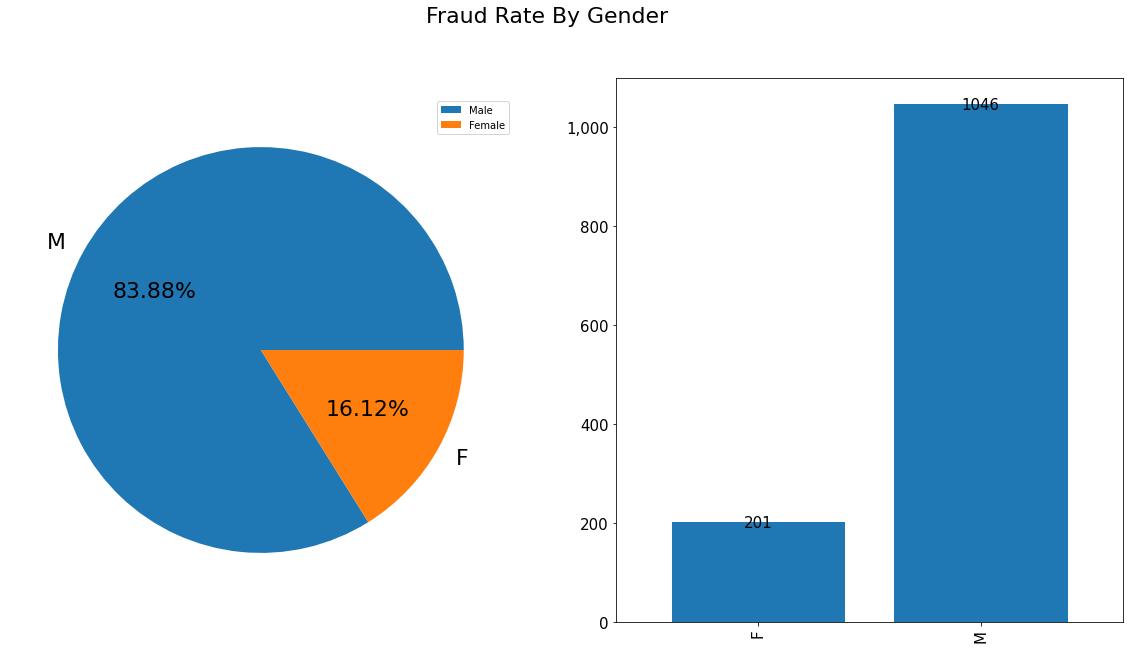

In [44]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.suptitle('Fraud Rate By Gender\n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")

ax8 = df_fraud['Rndrng_Prvdr_Gndr'].value_counts().plot(kind = 'pie',autopct='%.2f%%',ax=axes[0]
                                                        ,fontsize = "22" ,label='')
ax8.legend( labels=['Male','Female'], loc='best')

ax9=df_fraud['Rndrng_Prvdr_Gndr'].value_counts(ascending=True).plot(kind='bar',ax=axes[1],fontsize=15,width=0.78)
for p in ax9.patches:                 
    ax9.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=15)
ax9.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#### 3.2.2. Fraud rate by year

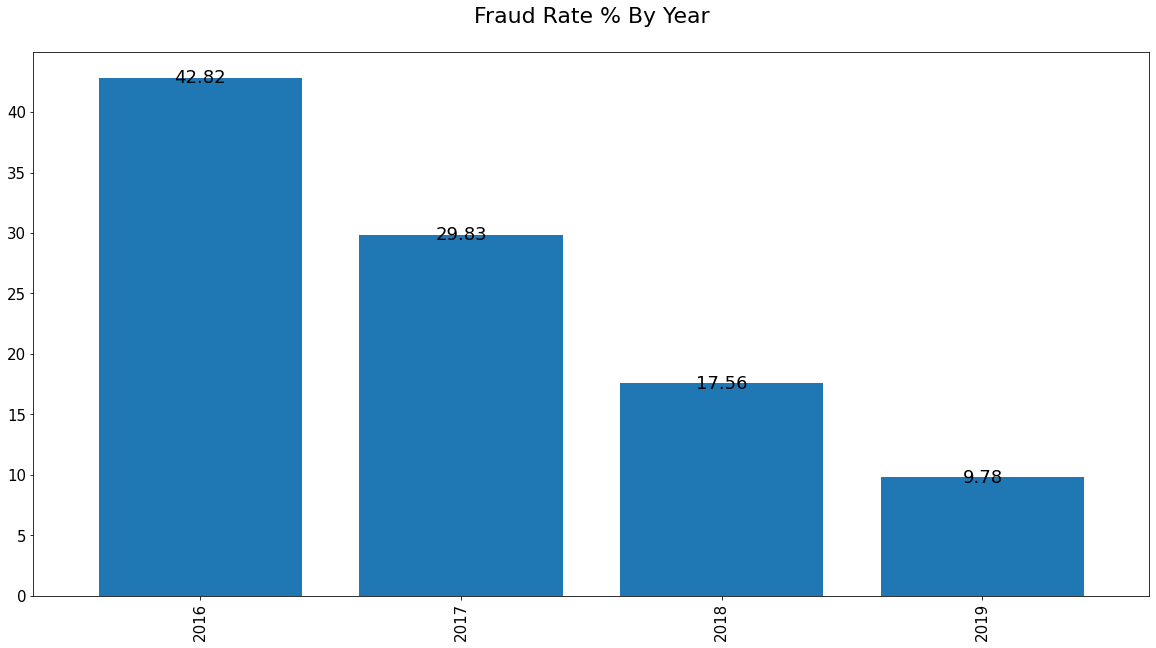

In [45]:
ax10=(df_fraud['year'].value_counts(ascending=False)*100/df_fraud.shape[0]).plot(kind='bar',fontsize=15,width=0.78)
for p in ax10.patches:                 
    ax10.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center',
                fontsize=18)
ax10.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Fraud Rate % By Year\n',horizontalalignment="center", fontstyle = "normal", 
             fontsize = "22", fontfamily = "sans-serif")
plt.show()

#### 3.2.3. Fraud rate by speciality

In [46]:
print('Top 10 most fraudulent providers type :')

(df_fraud['Rndrng_Prvdr_Type'].value_counts().to_frame()*100/df_fraud.shape[0]).head(10)

Top 10 most fraudulent providers type :


,Rndrng_Prvdr_Type
Internal Medicine,17.402
Family Practice,15.477
Nurse Practitioner,5.854
Chiropractic,5.293
Psychiatry,5.052
Emergency Medicine,4.170
Podiatry,4.010
Anesthesiology,3.929
Obstetrics & Gynecology,3.448
Physical Medicine and Rehabilitation,3.128


In [47]:
print('Top 10 most fraudulent providers states :')

(df_fraud['Rndrng_Prvdr_State_Abrvtn'].value_counts().to_frame()*100/df_fraud.shape[0]).head(10)

Top 10 most fraudulent providers states :


,Rndrng_Prvdr_State_Abrvtn
FL,12.430
NY,10.746
CA,9.142
TX,7.137
IL,6.095
MI,4.731
PA,3.849
GA,3.528
OH,3.448
NJ,3.047


__NOTES:__

- Fraudulent male practitioners are more present in the data set
- Fraud rate decreases over the years
- 'Internal Medicine' is the most fraudulent speciality
- 'Florida' is the most fraudulent state